In [50]:
import pandas as pd
import numpy as np

# 1. Load your stock-level signals
df = pd.read_csv("Stock level signals.csv")

# 2. Rename excess return column for consistency with slides
df = df.rename(columns={"re": "ret"})

# (Optional but nice) standardize permno name
# df = df.rename(columns={"permno": "PERMNO"})

In [51]:
meta_cols = ["permno", "date", "price", "age"]
ret_col  = "ret"

char_cols = [c for c in df.columns if c not in meta_cols + [ret_col]]

print("Number of characteristics J:", len(char_cols))
print("First few characteristics:", char_cols[:10])


Number of characteristics J: 52
First few characteristics: ['size', 'value', 'prof', 'dur', 'valprof', 'fscore', 'debtiss', 'repurch', 'nissa', 'accruals']


In [52]:
# Parse date as a proper period or datetime (your choice)
df["date"] = pd.to_datetime(df["date"], format="%m/%Y")

# Sort by time then permno
df = df.sort_values(["date", "permno"]).reset_index(drop=True)


In [53]:
import warnings
warnings.filterwarnings("ignore")


In [54]:
epsilon = 1e-8
def build_panel_matrices(df, char_cols, 
                         ret_col="ret", 
                         id_col="permno", 
                         date_col="date"):
    """
    From the long panel df → lists of (X_t, z_t, ids_t) over t.
    """
    df = df.sort_values([date_col, id_col])
    
    dates = df[date_col].drop_duplicates().sort_values().tolist()
    
    X_list   = []
    Z_list   = []
    ids_list = []
    
    for d in dates:
        tmp = df[df[date_col] == d].copy()
        
        # Drop rows with missing RET or any characteristic

        for col in [ret_col] + char_cols:
            try:
                median_val = tmp[col].median()
            except Exception:
                median_val = 0.0
            if pd.isna(median_val):
                median_val = 0.0
            tmp[col] = tmp[col].fillna(median_val)


        if tmp.empty:
            # if everything is NaN for that month, skip
            continue
        
        ids = tmp[id_col].values                # (N_t,)
        z   = tmp[ret_col].values              # (N_t,)
        X   = tmp[char_cols].values            # (N_t, J_char)
        
        # Add constant column (intercept) as in slides
        const = np.ones((X.shape[0], 1))       # (N_t, 1)
        X_full = np.hstack([const, X])         # (N_t, 1 + J_char)
        
        ids_list.append(ids)
        Z_list.append(z)
        X_list.append(X_full)
    
    return dates, ids_list, Z_list, X_list


dates, ids_list, Z_list, X_list = build_panel_matrices(df, char_cols)

# print("Number of months T:", len(dates))
# print("Example month:", dates[0])
# print("Shape of X_0 (N_0 × J):", X_list[0].shape)
# print("Length of z_0:", len(Z_list[0]))
# print("First few permnos in month 0:", ids_list[0][:5])


In [55]:
def compute_ols_factors(Z_list, X_list, ridge=1e-6):
    """
    OLS factors: f_{t+1} = (X_t' X_t)^{-1} X_t' z_{t+1}
    
    ridge: small regularization added to X'X diag for numerical stability.
    
    Returns:
        F_ols: (T, J) array of OLS factor coefficients per period.
    """
    T = len(Z_list)
    J = X_list[0].shape[1]
    
    F_ols = np.zeros((T, J))
    
    for t in range(T):
        z_t = Z_list[t].reshape(-1, 1)  # (N_t, 1)
        X_t = X_list[t]                 # (N_t, J)
        
        XtX = X_t.T @ X_t               # (J, J)
        XtX_reg = XtX + ridge * np.eye(J)
        XtZ = X_t.T @ z_t               # (J, 1)
        
        beta_t = np.linalg.solve(XtX_reg, XtZ)  # (J, 1)
        F_ols[t, :] = beta_t.flatten()
    
    return F_ols

F_ols = compute_ols_factors(Z_list, X_list)
print("OLS factor matrix shape (T × J):", F_ols.shape)
# print("First-row OLS factors:", F_ols[0, :5])


OLS factor matrix shape (T × J): (678, 53)


In [56]:
import numpy as np

def compute_univariate_factors(Z_list, X_list):
    """
    Univariate factors: f_{t+1} = X_t' z_{t+1}
    
    Inputs:
        Z_list: list of length T, each element (N_t,) array of returns z_{t+1}
        X_list: list of length T, each element (N_t, J) array of characteristics (+constant)
    Returns:
        F_uni: (T, J) array – one factor per column of X (constant + each characteristic)
    """
    T = len(Z_list)
    J = X_list[0].shape[1]
    
    F_uni = np.zeros((T, J))
    
    for t in range(T):
        z_t = Z_list[t].reshape(-1, 1)  # (N_t, 1)
        X_t = X_list[t]                 # (N_t, J)
        
        f_t = X_t.T @ z_t               # (J, 1)
        F_uni[t, :] = f_t.flatten()
    
    return F_uni

F_uni = compute_univariate_factors(Z_list, X_list)
print("Univariate factor matrix shape (T × J):", F_uni.shape)
# print("First-row univariate factors:", F_uni[0, :5])


Univariate factor matrix shape (T × J): (678, 53)


In [57]:
def sdf_from_factors(F, freq=12, use_pinv=True):
    """
    Maximum squared Sharpe ratio in the span of factor returns F.

    Parameters
    ----------
    F : array-like (T × K)
        Time series of factor excess returns (e.g., monthly).
    freq : int
        Number of periods per year (12 for monthly, 252 for daily, etc.).
    use_pinv : bool
        If True, use Moore–Penrose pseudo-inverse for Sigma_f.

    Returns
    -------
    sr  : float
        Annualized maximum Sharpe ratio.
    sr2 : float
        Annualized maximum squared Sharpe ratio (mu' Sigma^{-1} mu, annualized).
    """
    F = np.asarray(F)
    mu_f = F.mean(axis=0).reshape(-1, 1)    # K×1
    Sigma_f = np.cov(F.T)                   # K×K

    if use_pinv:
        Sigma_inv = np.linalg.pinv(Sigma_f)
    else:
        Sigma_inv = np.linalg.inv(Sigma_f)

    # Monthly (or per-period) squared SR
    sr2_period = float(mu_f.T @ Sigma_inv @ mu_f)

    # Annualize: SR^2_ann = freq * SR^2_period
    sr2_annual = freq * sr2_period
    sr_annual = np.sqrt(sr2_annual)

    return sr_annual, sr2_annual


In [58]:
sr_uni, _ = sdf_from_factors(F_uni)
sr_ols, _ = sdf_from_factors(F_ols)

print("SDF Sharpe (univariate factors):", sr_uni)
print("SDF Sharpe (OLS factors)      :", sr_ols)


SDF Sharpe (univariate factors): 3.3986533491203432
SDF Sharpe (OLS factors)      : 4.313316576974138


In [59]:
# Per-stock time-series std of returns
sigma_by_stock = df.groupby("date")["ret"].std(ddof=1)

# Fallback: replace any NaNs with overall std
overall_sigma = sigma_by_stock.median()
sigma_by_stock = sigma_by_stock.fillna(overall_sigma)

In [60]:
sigma_by_stock.shape

(678,)

In [61]:
import numpy as np
import pandas as pd

# Ensure sorted by stock and date
df = df.sort_values(["permno", "date"])

# Rolling 36-month volatility per stock (tweak window/min_periods if you want)
df["sigma_roll"] = (
    df.groupby("permno")["ret"]
      .rolling(window=36, min_periods=12)
      .std(ddof=1)
      .reset_index(level=0, drop=True)
)

# If very early months have all-NaN sigma_roll for a stock, fill later
overall_sigma = df["ret"].std(ddof=1)
df["sigma_roll"] = df["sigma_roll"].fillna(overall_sigma)

# Convenience index for fast lookup: (date, permno) -> sigma_roll
sigma_panel = df.set_index(["date", "permno"])["sigma_roll"]
Sigma_diag_list = []   # list of (N_t,) arrays of sigma_{i,t}^2

for d, ids_t in zip(dates, ids_list):
    # Build MultiIndex (date, permno) in the correct order
    mi = pd.MultiIndex.from_arrays(
        [np.repeat(d, len(ids_t)), ids_t],
        names=["date", "permno"]
    )
    sig_t = sigma_panel.reindex(mi).to_numpy()

    # Fallback: if any missing, plug cross-sectional median for that date
    bad = ~np.isfinite(sig_t)
    if bad.any():
        # try cross-sectional median for that date; if still NaN, use overall_sigma
        median_t = np.nanmedian(sig_t)
        if not np.isfinite(median_t):
            median_t = overall_sigma
        sig_t[bad] = median_t

    Sigma_diag_list.append(sig_t**2)   # store variances σ_{i,t}^2


In [62]:
def compute_gls_factors_diagSigma_t(Z_list, X_list, Sigma_diag_list, ridge=1e-6):
    T = len(Z_list)
    J = X_list[0].shape[1]
    F_gls = np.zeros((T, J))

    for t in range(T):
        z_t = Z_list[t].reshape(-1, 1)
        X_t = X_list[t]
        sigma2_t = Sigma_diag_list[t]  # (N_t,)

        w_t = 1.0 / (sigma2_t + 1e-12)
        W_half = np.sqrt(w_t).reshape(-1, 1)

        Xw = X_t * W_half
        zw = z_t * W_half

        XtWX = Xw.T @ Xw
        XtWz = Xw.T @ zw
        XtWX_reg = XtWX + ridge * np.eye(J)

        f_t = np.linalg.solve(XtWX_reg, XtWz)
        F_gls[t, :] = f_t.ravel()

    return F_gls


In [63]:
F_gls = compute_gls_factors_diagSigma_t(Z_list, X_list, Sigma_diag_list)
print("GLS factor matrix shape (T × J):", F_gls.shape)


GLS factor matrix shape (T × J): (678, 53)


In [64]:

sr_uni, _ = sdf_from_factors(F_uni)
sr_ols, _ = sdf_from_factors(F_ols)
sr_gls, _ = sdf_from_factors(F_gls)

print("Span SR (univariate):", sr_uni)
print("Span SR (OLS)       :", sr_ols)
print("Span SR (GLS diag Σ):", sr_gls)


Span SR (univariate): 3.3986533491203432
Span SR (OLS)       : 4.313316576974138
Span SR (GLS diag Σ): 4.523126595527614


In [65]:
import numpy as np

def hedge_characteristics_X(X_list, ridge=1e-6, include_const=True):
    """
    Cross-sectional hedging of characteristics:
        For each t and each j>=1, regress x_{j,t} on other columns of X_t
        and take residuals.

    Parameters
    ----------
    X_list       : list of (N_t, J) arrays (col 0 assumed to be constant 1s).
    ridge        : float, diagonal ridge added to X'X.
    include_const: bool, if True include constant column in the 'other' regressors.

    Returns
    -------
    H_list : list of (N_t, J) arrays of hedged characteristics.
             Column 0 (constant) is copied from X_t.
    """
    H_list = []

    for X_t in X_list:
        X_t = np.asarray(X_t)
        N_t, J = X_t.shape
        H_t = np.zeros_like(X_t)

        # keep constant
        H_t[:, 0] = X_t[:, 0]

        for j in range(1, J):
            x_j = X_t[:, [j]]      # (N_t, 1)

            # mask for all columns except j
            mask = np.ones(J, dtype=bool)
            mask[j] = False
            if not include_const:
                mask[0] = False    # drop constant from regressors if desired

            X_minus = X_t[:, mask]    # (N_t, J-1 or J-2)

            # clean any non-finites (just in case)
            good = np.all(np.isfinite(X_minus), axis=1) & np.isfinite(x_j.ravel())
            X_use = X_minus[good]
            y_use = x_j[good]

            XtX = X_use.T @ X_use
            XtX_reg = XtX + ridge * np.eye(XtX.shape[0])
            Xt_y = X_use.T @ y_use

            coeff = np.linalg.solve(XtX_reg, Xt_y)   # (k, 1)
            proj = X_minus @ coeff                   # (N_t, 1), full N_t using all rows

            H_t[:, j] = (x_j - proj).ravel()

        H_list.append(H_t)

    return H_list


In [66]:
H_list = hedge_characteristics_X(X_list)


In [67]:
def compute_univariate_factors(Z_list, X_list):
    T = len(Z_list)
    J = X_list[0].shape[1]
    F_uni = np.zeros((T, J))
    for t in range(T):
        z_t = Z_list[t].reshape(-1, 1)
        X_t = X_list[t]
        F_uni[t, :] = (X_t.T @ z_t).ravel()
    return F_uni

import numpy as np

def span_sharpe_from_factors(F, freq=12, ridge=1e-8):
    """
    Maximum Sharpe ratio and squared Sharpe ratio in the span of factor returns F.

    F     : (T × K) array of factor excess returns (per period, e.g. monthly).
    freq  : periods per year (1 for per-period SR^2, 12 for annualized from monthly).
    ridge : small diagonal loading added to Sigma_f for numerical stability.

    Returns
    -------
    sr  : float
        Max Sharpe ratio in the span (after scaling by freq).
    sr2 : float
        Max squared Sharpe ratio in the span (after scaling by freq).
    """
    F = np.asarray(F)

    # Ensure 2D: (T,) -> (T,1)
    if F.ndim == 1:
        F = F.reshape(-1, 1)

    T, K = F.shape
    mu_f = F.mean(axis=0).reshape(-1, 1)   # K×1

    if K == 1:
        # Single-factor case: variance is scalar
        sigma2 = float(np.var(F, ddof=1)) + ridge
        sr2_period = float(mu_f[0, 0] ** 2 / sigma2)
    else:
        Sigma_f = np.cov(F.T)                  # K×K
        Sigma_f = Sigma_f + ridge * np.eye(K)  # stabilize
        sr2_period = float(mu_f.T @ np.linalg.inv(Sigma_f) @ mu_f)

    # Optionally annualize: SR^2_ann = freq * SR^2_period
    sr2 = freq * sr2_period
    sr = np.sqrt(sr2)
    return sr, sr2



In [68]:
# Unhedged univariate factors (you already have these)
F_uni = compute_univariate_factors(Z_list, X_list)
sr_uni, sr2_uni = span_sharpe_from_factors(F_uni)

# Hedged univariate factors (using H_list)
F_uni_hedged = compute_univariate_factors(Z_list, H_list)
sr_uni_h, sr2_uni_h = span_sharpe_from_factors(F_uni_hedged)

print("Span SR (univariate, unhedged):", sr_uni)
print("Span SR (univariate, hedged)  :", sr_uni_h)


Span SR (univariate, unhedged): 3.397688530636213
Span SR (univariate, hedged)  : 4.100647287140464


In [69]:
# Assuming you've already built GLS factors F_gls:
# F_gls = compute_gls_factors_diagSigma(Z_list, X_list, ids_list, sigma_by_stock)
sr_gls, sr2_gls = span_sharpe_from_factors(F_gls)

print("Span SR (univariate, unhedged):", sr_uni)
print("Span SR (univariate, hedged)  :", sr_uni_h)
print("Span SR (GLS diag Σ)          :", sr_gls)

print("\nFraction of GLS SR captured:")
print("  Unhedged :", sr_uni  / sr_gls)
print("  Hedged   :", sr_uni_h / sr_gls)


Span SR (univariate, unhedged): 3.397688530636213
Span SR (univariate, hedged)  : 4.100647287140464
Span SR (GLS diag Σ)          : 4.5231255219522275

Fraction of GLS SR captured:
  Unhedged : 0.7511815699445227
  Hedged   : 0.9065959516795772


In [70]:
def iterated_hedging_SR(Z_list, X_list, n_iter, ridge=1e-6):
    """
    Apply hedging 0,1,...,n_iter times and record span SR
    of the corresponding univariate factors each time.
    """
    X_cur = X_list
    sr_list = []

    for k in range(n_iter + 1):
        F_uni_k = compute_univariate_factors(Z_list, X_cur)
        sr_k, sr2_k = span_sharpe_from_factors(F_uni_k)
        sr_list.append(sr_k)

        # prepare for next iteration
        X_cur = hedge_characteristics_X(X_cur, ridge=ridge)

    return sr_list

# Example: 0x (unhedged), 1x, 2x, 3x hedged
sr_iters = iterated_hedging_SR(Z_list, X_list, n_iter=3)
for k, sr_k in enumerate(sr_iters):
    print(f"Iter {k} (hedged {k}×) span SR = {sr_k:.4f}")


Iter 0 (hedged 0×) span SR = 3.3977
Iter 1 (hedged 1×) span SR = 4.1006
Iter 2 (hedged 2×) span SR = 3.5554
Iter 3 (hedged 3×) span SR = 3.6643


In [71]:
# 0x hedged = original X_list
X0 = X_list

# 1x, 2x, 3x hedged characteristics
X1 = hedge_characteristics_X(X0)
X2 = hedge_characteristics_X(X1)
X3 = hedge_characteristics_X(X2)



In [72]:
F_ols_0 = compute_ols_factors(Z_list, X0)  # unhedged OLS
F_ols_1 = compute_ols_factors(Z_list, X1)  # hedged 1x
F_ols_2 = compute_ols_factors(Z_list, X2)  # hedged 2x
F_ols_3 = compute_ols_factors(Z_list, X3)  # hedged 3x


In [73]:
sr_ols_0, sr2_ols_0 = span_sharpe_from_factors(F_ols_0)
sr_ols_1, sr2_ols_1 = span_sharpe_from_factors(F_ols_1)
sr_ols_2, sr2_ols_2 = span_sharpe_from_factors(F_ols_2)
sr_ols_3, sr2_ols_3 = span_sharpe_from_factors(F_ols_3)

print("Span SR (OLS, 0x hedged):", sr_ols_0)
print("Span SR (OLS, 1x hedged):", sr_ols_1)
print("Span SR (OLS, 2x hedged):", sr_ols_2)
print("Span SR (OLS, 3x hedged):", sr_ols_3)

# If you already have F_gls:
# F_gls = compute_gls_factors_diagSigma(...)
sr_gls, sr2_gls = span_sharpe_from_factors(F_gls)
print("Span SR (GLS diag Σ)    :", sr_gls)


Span SR (OLS, 0x hedged): 4.313315827019291
Span SR (OLS, 1x hedged): 3.2726742931027055
Span SR (OLS, 2x hedged): 3.80067219121669
Span SR (OLS, 3x hedged): 3.6206241195701443
Span SR (GLS diag Σ)    : 4.5231255219522275


In [74]:
def pca_truncate(F, K):
    """
    Take factor returns F (T × J), return top K principal component factors (T × K).
    """
    F = np.asarray(F)
    T, J = F.shape

    # Covariance of factors (np.cov centers internally)
    Sigma_f = np.cov(F.T)              # J×J

    # Eigen-decomposition (symmetric)
    eigvals, eigvecs = np.linalg.eigh(Sigma_f)
    idx = np.argsort(eigvals)[::-1]    # sort by eigenvalue desc
    eigvecs = eigvecs[:, idx]          # J×J

    eigvecs_K = eigvecs[:, :K]         # J×K

    # IMPORTANT: project the original F, not the centered one
    F_pca = F @ eigvecs_K              # T×K

    return F_pca

In [75]:
import numpy as np
import pandas as pd

# ---------- 1. Univariate factor sets (0x..3x hedged) ----------

# 0x hedged = original X_list
X0 = X_list
# If you haven't already:
# X1 = hedge_characteristics_X(X0)
# X2 = hedge_characteristics_X(X1)
# X3 = hedge_characteristics_X(X2)

F_uni_0 = compute_univariate_factors(Z_list, X0)
F_uni_1 = compute_univariate_factors(Z_list, X1)
F_uni_2 = compute_univariate_factors(Z_list, X2)
F_uni_3 = compute_univariate_factors(Z_list, X3)

# ---------- 2. OLS factor sets already computed ----------
# F_ols_0, F_ols_1, F_ols_2, F_ols_3
# F_gls

# ---------- 3. Loop over K and store SR^2 ----------
    
K_max = 55
Ks = np.arange(2, K_max + 1)

ols_unhedged_sr2 = []
ols_h1_sr2 = []
ols_h2_sr2 = []
ols_h3_sr2 = []
ols_gls_sr2 = []

uni_unhedged_sr2 = []
uni_h1_sr2 = []
uni_h2_sr2 = []
uni_h3_sr2 = []
uni_gls_sr2 = []

for K in Ks:
    # ----- OLS factors -----
    F0K = pca_truncate(F_ols_0, K)
    F1K = pca_truncate(F_ols_1, K)
    F2K = pca_truncate(F_ols_2, K)
    F3K = pca_truncate(F_ols_3, K)
    FGK = pca_truncate(F_gls,    K)

    _, sr2_ols0 = span_sharpe_from_factors(F0K)
    _, sr2_ols1 = span_sharpe_from_factors(F1K)
    _, sr2_ols2 = span_sharpe_from_factors(F2K)
    _, sr2_ols3 = span_sharpe_from_factors(F3K)
    _, sr2_olsg = span_sharpe_from_factors(FGK)

    ols_unhedged_sr2.append(sr2_ols0)
    ols_h1_sr2.append(sr2_ols1)
    ols_h2_sr2.append(sr2_ols2)
    ols_h3_sr2.append(sr2_ols3)
    ols_gls_sr2.append(sr2_olsg)

    # ----- Univariate factors -----
    U0K = pca_truncate(F_uni_0, K)
    U1K = pca_truncate(F_uni_1, K)
    U2K = pca_truncate(F_uni_2, K)
    U3K = pca_truncate(F_uni_3, K)
    UGK = pca_truncate(F_gls,    K)   # same GLS benchmark

    _, sr2_uni0 = span_sharpe_from_factors(U0K)
    _, sr2_uni1 = span_sharpe_from_factors(U1K)
    _, sr2_uni2 = span_sharpe_from_factors(U2K)
    _, sr2_uni3 = span_sharpe_from_factors(U3K)
    _, sr2_unig = span_sharpe_from_factors(UGK)

    uni_unhedged_sr2.append(sr2_uni0)
    uni_h1_sr2.append(sr2_uni1)
    uni_h2_sr2.append(sr2_uni2)
    uni_h3_sr2.append(sr2_uni3)
    uni_gls_sr2.append(sr2_unig)

# ---------- 4. DataFrames for plotting ----------

# (A) Levels: IS squared SR with and without hedging (OLS slide 1)
df_ols_sr2 = pd.DataFrame({
    "Unhedged": ols_unhedged_sr2,
    "Hedged 1x": ols_h1_sr2,
    "Hedged 2x": ols_h2_sr2,
    "Hedged 3x": ols_h3_sr2,
    "GLS (pca)": ols_gls_sr2,
}, index=Ks)

# (B) Improvements: OLS slide 2
df_ols_impr = pd.DataFrame({
    "Hedged 1x": 100 * (np.array(ols_h1_sr2) - np.array(ols_unhedged_sr2)) / np.array(ols_unhedged_sr2),
    "Hedged 2x": 100 * (np.array(ols_h2_sr2) - np.array(ols_unhedged_sr2)) / np.array(ols_unhedged_sr2),
    "Hedged 3x": 100 * (np.array(ols_h3_sr2) - np.array(ols_unhedged_sr2)) / np.array(ols_unhedged_sr2),
    "GLS (pca)": 100 * (np.array(ols_gls_sr2) - np.array(ols_unhedged_sr2)) / np.array(ols_unhedged_sr2),
}, index=Ks)

# (C) Improvements: Univariate slide 3
df_uni_impr = pd.DataFrame({
    "Hedged 1x": 100 * (np.array(uni_h1_sr2) - np.array(uni_unhedged_sr2)) / np.array(uni_unhedged_sr2),
    "Hedged 2x": 100 * (np.array(uni_h2_sr2) - np.array(uni_unhedged_sr2)) / np.array(uni_unhedged_sr2),
    "Hedged 3x": 100 * (np.array(uni_h3_sr2) - np.array(uni_unhedged_sr2)) / np.array(uni_unhedged_sr2),
    "GLS (pca)": 100 * (np.array(uni_gls_sr2) - np.array(uni_unhedged_sr2)) / np.array(uni_unhedged_sr2),
}, index=Ks)

# (D) Levels: IS squared SR with and without hedging (Univariate slide 4)
df_uni_sr2 = pd.DataFrame({
    "Unhedged": uni_unhedged_sr2,
    "Hedged 1x": uni_h1_sr2,
    "Hedged 2x": uni_h2_sr2,
    "Hedged 3x": uni_h3_sr2,
    "GLS (pca)": uni_gls_sr2,
}, index=Ks)

# Quick sanity check
print(df_ols_sr2.head())
print(df_ols_impr.head())
print(df_uni_impr.head())


   Unhedged  Hedged 1x  Hedged 2x  Hedged 3x  GLS (pca)
2  0.055689   0.106275   0.028620   0.061156   0.112083
3  0.205342   0.570717   0.068411   0.962703   0.233373
4  0.398350   1.345625   0.102893   0.965634   0.268223
5  0.398350   1.460288   0.169718   0.998583   0.268294
6  0.432499   1.694610   0.909088   1.060209   0.393714
    Hedged 1x   Hedged 2x   Hedged 3x   GLS (pca)
2   90.838255  -48.607305    9.818771  101.268015
3  177.935296  -66.684198  368.829532   13.651117
4  237.800051  -74.170067  142.408557  -32.666345
5  266.584394  -57.394656  150.679950  -32.648582
6  291.817869  110.193980  145.135453   -8.967662
   Hedged 1x  Hedged 2x  Hedged 3x  GLS (pca)
2 -54.006342 -11.619510 -53.615488 -74.759693
3   3.901570  44.340466 -71.094691 -70.228326
4 -10.071543  26.359805 -72.930329 -70.654586
5  38.252760  34.072613  17.093858 -70.832681
6 -13.744906 -32.808836 -35.702175 -78.704223


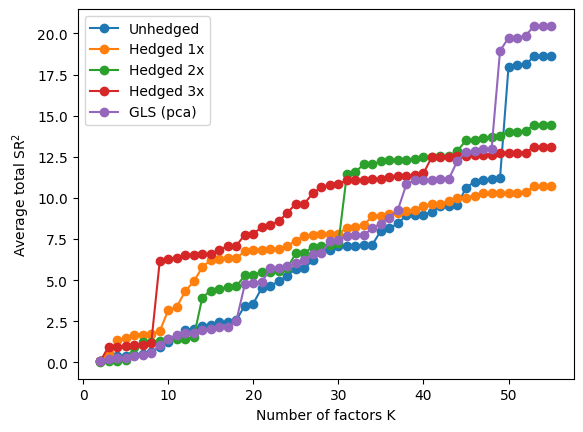

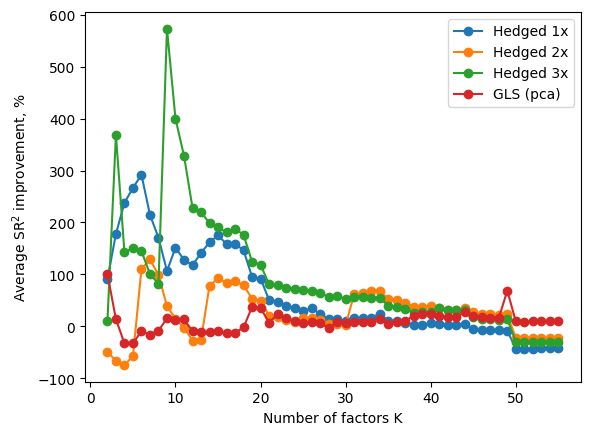

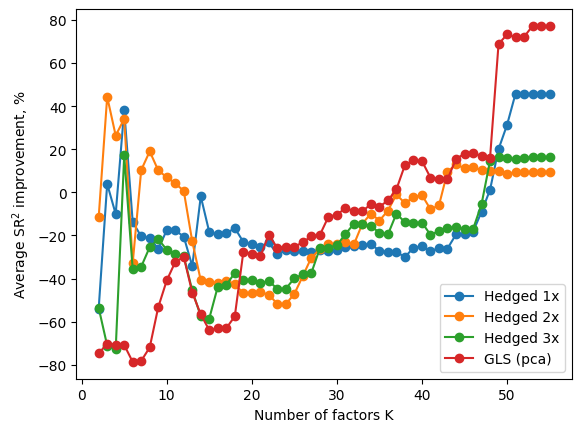

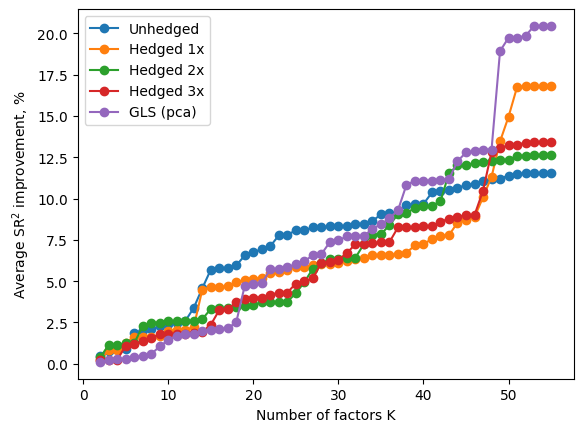

In [ ]:
import matplotlib.pyplot as plt
# Slide 1
df_ols_sr2.plot(marker="o")
plt.xlabel("Number of factors K")
plt.ylabel("Average total SR$^2$")
plt.show()

# Slide 2
df_ols_impr.plot(marker="o")
plt.xlabel("Number of factors K")
plt.ylabel("Average SR$^2$ improvement, %")
plt.show()

# Slide 3
df_uni_impr.plot(marker="o")
plt.xlabel("Number of factors K")
plt.ylabel("Average SR$^2$ improvement, %")
plt.show()

# Slide 4
df_uni_sr2.plot(marker="o")
plt.xlabel("Number of factors K")
plt.ylabel("Average total SR$^2$ %")
plt.show()


In [87]:
import pandas as pd
from kozak_pipe import run_kozak

# You prepare df however you like (from CSV, DB, whatever)
df = pd.read_csv("Stock level signals.csv")

results = run_kozak(df)

ImportError: cannot import name 'run_kozak' from 'kozak_pipe' (/Users/hiteshkumar/Desktop/GaTech/Classes/Fin & Inv/Project/kozak_pipe.py)

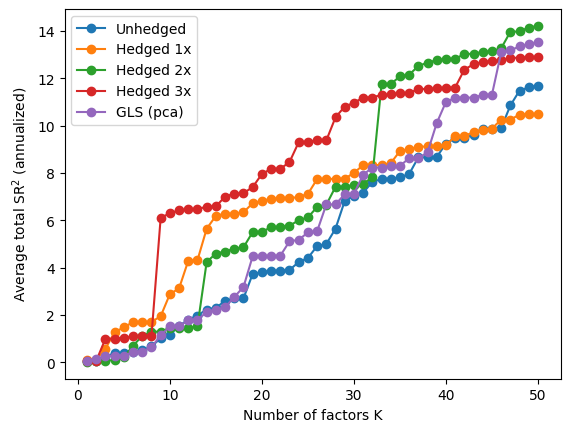

In [83]:

df_ols_sr2   = results["df_ols_sr2"]
df_ols_impr  = results["df_ols_impr"]
df_uni_sr2   = results["df_uni_sr2"]
df_uni_impr  = results["df_uni_impr"]

# Then you can recreate your notebook plots:
import matplotlib.pyplot as plt

df_ols_sr2.plot(marker="o")
plt.xlabel("Number of factors K")
plt.ylabel("Average total SR$^2$ (annualized)")
plt.show()


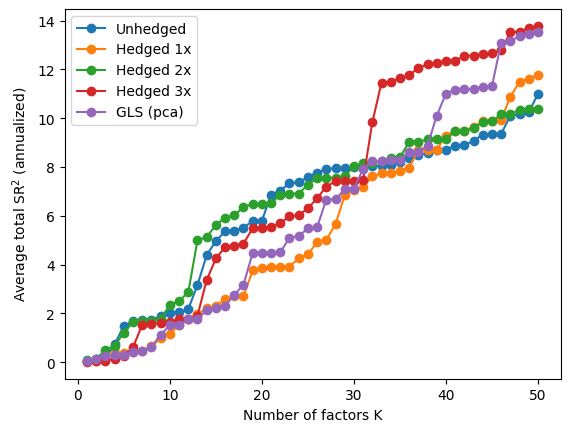

In [84]:
df_uni_sr2.plot(marker="o")
plt.xlabel("Number of factors K")
plt.ylabel("Average total SR$^2$ (annualized)")
plt.show()
